__NOTES REPRODUCING:__

<u>Files and file locations</u>

- Please download __train.csv__ (247Mb) and __VariableDefinitions.csv__ (1.4Kb) from https://zindi.africa/competitions/expresso-churn-prediction/data
- __train.csv__ may be renamed to __expresso_train.csv__ and placed at an appropriate location on HDFS
- Update the HDFS location in cells 3 and 31 with your own location
- __VariableDefinitions.csv__ may be placed in the same location as the Jupyter Notebook
- Image file __train-test-splits.png__ supplied in the submission may be placed in the same location as the Jupyter Notebook

<u>Reduced hyperparameter spaces</u>

- To test cross-validation with a smaller number of hyperparameters you may substitute in the reduced searchspace under __# Reduced searchspace__ in cells 38, 39, and 40

# 1. Topic proposal

## 1.1 Introduction

Predicting customer churn is a common application of machine learning in many industries. The main idea is to use a variety of data points reflecting customers and their behaviour to predict whether a customer will stop buying a product or service. It is essentially a binary classification problem: churn vs not-churn.

I selected this project as it is a topic of interest to the company where I currently work: a news media company that offers a subscription-based service. Identifying customers who are at risk of churning is useful to business because various retention interventions can be considered for high-risk customers: for example, contacting the customer to offer a discount on the next purchase, recommending a product or content that is likely to appeal to the customer, and so on.

The dataset I have selected is available on the Zindi Africa platform: the [Expresso Churn Prediction Challenge](https://zindi.africa/competitions/expresso-churn-prediction) - the dataset (named __train.csv__) may be downloaded from this location. "Expresso is an African telecommunications company that provides customers with airtime and mobile data bundles. The objective of this challenge is to develop a machine learning model to predict the likelihood of each Expresso customer “churning”, i.e. becoming inactive and not making any transactions for 90 days" and the stated evaluation metric for the task is Area Under the Curve (AUC) (Zindi, 2021).

At 247Mb (~2.1 million records) it is a smallish dataset in Hadoop terms, but illustrates well how such a task can be tackled using PySpark and PySpark ML which is the DataFrame-based machine learning API (Apache Spark, 2023). I am using version 3.0.1.

Note: at the time of writing (mid-August) the Expresso company website is unavailable. Upon further investigation I discovered that the Senegalese government has been imposing internet blackouts on the country since 31 July which probably accounts for this (Atabong, 2023). As a result I used some secondary data sources to get certain background information for my project.

#### Library Imports

The following libraries will be used in this project. Note the seaborn library was not initially available on my default environment. If required, uncomment the first 2 lines to install it before proceeding (you may need to restart the kernel after doing so for the installation to register):

In [1]:
# import sys
# !{sys.executable} -m pip install seaborn

In [2]:
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SparkSession
spark = SparkSession(sc)
import pyspark.sql.functions as fn
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, RobustScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.functions import vector_to_array
import time
import inspect
import itertools
from pprint import pprint
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 500)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(palette = 'husl', style = 'darkgrid', rc = {'figure.figsize':(7, 5)})
notebook_start = time.time()
spark

## 1.2 Data

The data exploration phase serves 3 purposes:

1. Understand our feature and target variables and what they represent
2. Gain insights into whether the given data has sufficient 'signal' for us to be able to predict whether a customer churns or not
3. Assess what transformations the data will require in order to be used in subsequent machine learning models

### 1.2.1 Data Imports

The main file ```expresso_train.csv``` has been placed on HDFS already. Let's begin by reading it in and checking that the result is a pyspark DataFrame, and the number of partitions holding the data:

In [3]:
df = spark.read.csv("hdfs://lena/user/<username>/coursework2/expresso_train.csv", inferSchema = True, header= True)
print(f'''Resulting data type:   {type(df)}''')
print(f'''Number of partitions:  {df.rdd.getNumPartitions()}''')

Resulting data type:   <class 'pyspark.sql.dataframe.DataFrame'>
Number of partitions:  2


A small supplementary file called ```VariableDefinitions.csv``` is supplied which tells us what columns we should expect in the dataset - here are those descriptions:

In [4]:
variable_defs = pd.read_csv('VariableDefinitions.csv', 
                            usecols=[0,2], skiprows=[0, 1, 2], 
                            names = ['variable', 'description'])
variable_defs

,variable,description
0,user_id,NaN
1,REGION,the location of each client
2,TENURE,duration in the network
3,MONTANT,top-up amount
4,FREQUENCE_RECH,number of times the customer refilled
5,REVENUE,monthly income of each client
6,ARPU_SEGMENT,income over 90 days / 3
7,FREQUENCE,number of times the client has made an income
8,DATA_VOLUME,number of connections
9,ON_NET,inter expresso call


Now let's check the schema of our DataFrame:

In [5]:
df.printSchema()
print(f'''Number of records: {df.count()}''')

root
 |-- user_id: string (nullable = true)
 |-- REGION: string (nullable = true)
 |-- TENURE: string (nullable = true)
 |-- MONTANT: double (nullable = true)
 |-- FREQUENCE_RECH: double (nullable = true)
 |-- REVENUE: double (nullable = true)
 |-- ARPU_SEGMENT: double (nullable = true)
 |-- FREQUENCE: double (nullable = true)
 |-- DATA_VOLUME: double (nullable = true)
 |-- ON_NET: double (nullable = true)
 |-- ORANGE: double (nullable = true)
 |-- TIGO: double (nullable = true)
 |-- ZONE1: double (nullable = true)
 |-- ZONE2: double (nullable = true)
 |-- MRG: string (nullable = true)
 |-- REGULARITY: integer (nullable = true)
 |-- TOP_PACK: string (nullable = true)
 |-- FREQ_TOP_PACK: double (nullable = true)
 |-- CHURN: integer (nullable = true)

Number of records: 2154048


All the expected columns are present. I found the performance on querying and filtering my DataFrame reasonably fast so I will conduct my initial analysis on the entire DataFrame of 2154048 records so as to know exactly what I am dealing with in the data. Later on I will sample the dataset to save time on certain tasks.


### 1.2.2 Data exploration

_Note that in this section I create a series of functions to clean the data as I find issues._

#### Data types

From the above schema we can see that all the expected columns are present. Most of the numeric columns have been inferred as 'double' but REGULARITY has been inferred as 'integer'. While some columns with descriptions like 'number of times' or 'number of calls' would naturally be expressed as 'integer' values, I'm going to convert all numeric columns to 'double' so that later on if we want to do operations like imputing nulls from the mean, or standardizing our data then the columns will already be an appropriate type for decimal values. 

<u>__Data transformation tasks__</u>: 

- Below I identify which columns I want as doubles. I then create a function ```cast_to_double``` to transform all required numeric columns to type 'double'.

In [6]:
doubles = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 
           'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2', 'REGULARITY', 'FREQ_TOP_PACK', 'CHURN']

def cast_to_double(df, columns):
    '''Transform required columns to double type'''
    return df.select(
                *(c for c in df.columns if c not in columns),
                *(fn.col(c).cast('double').alias(c) for c in columns)
               )
df = df.transform(lambda df: cast_to_double(df, doubles))

#### Data overview and nulls

Let's look at a couple of records:

In [7]:
df.show(2, vertical = True)

-RECORD 0------------------------------
 user_id        | 00000bfd7d50f0109... 
 REGION         | FATICK               
 TENURE         | K > 24 month         
 MRG            | NO                   
 TOP_PACK       | On net 200F=Unlim... 
 MONTANT        | 4250.0               
 FREQUENCE_RECH | 15.0                 
 REVENUE        | 4251.0               
 ARPU_SEGMENT   | 1417.0               
 FREQUENCE      | 17.0                 
 DATA_VOLUME    | 4.0                  
 ON_NET         | 388.0                
 ORANGE         | 46.0                 
 TIGO           | 1.0                  
 ZONE1          | 1.0                  
 ZONE2          | 2.0                  
 REGULARITY     | 54.0                 
 FREQ_TOP_PACK  | 8.0                  
 CHURN          | 0.0                  
-RECORD 1------------------------------
 user_id        | 00000cb4a5d760de8... 
 REGION         | null                 
 TENURE         | I 18-21 month        
 MRG            | NO                   


From the above it is clear we have some null values. Let's see the extent of the null value problem - it seems that many of the columns have > 33% of records with null values:

In [8]:
df.agg(*[
       (fn.round(1 - (fn.count(c) / fn.count('*')), 4)).alias(c + '_%nulls')
       for c in df.columns
]).show(vertical = True)

-RECORD 0-----------------------
 user_id_%nulls        | 0.0    
 REGION_%nulls         | 0.3943 
 TENURE_%nulls         | 0.0    
 MRG_%nulls            | 0.0    
 TOP_PACK_%nulls       | 0.419  
 MONTANT_%nulls        | 0.3513 
 FREQUENCE_RECH_%nulls | 0.3513 
 REVENUE_%nulls        | 0.3371 
 ARPU_SEGMENT_%nulls   | 0.3371 
 FREQUENCE_%nulls      | 0.3371 
 DATA_VOLUME_%nulls    | 0.4923 
 ON_NET_%nulls         | 0.3652 
 ORANGE_%nulls         | 0.4156 
 TIGO_%nulls           | 0.5989 
 ZONE1_%nulls          | 0.9212 
 ZONE2_%nulls          | 0.9365 
 REGULARITY_%nulls     | 0.0    
 FREQ_TOP_PACK_%nulls  | 0.419  
 CHURN_%nulls          | 0.0    



By examining each column in more detail we can get a sense of the relevance of each variable to the problem, and a better idea of how to handle null values. I have created 4 functions to make this exploration easier: ```show_categorical``` which will show us a table of counts per category for a column, ```plot_categorical_by_target``` which will show us the percentage of churners by category for a column, ```show_histogram``` which will show us the distribution of numerical variables, and ```show_metric_by_target``` which will show us the mean or median value per churn target:

In [9]:
def show_categorical(df, column):
    '''Takes in a df and column name and returns the count of records per column value
    and the percentage of total - count('*') is necessary so that null values also
    return a valid count rather than 0 which is the default behaviour.'''
    df.groupBy(column).agg(
    *[fn.count('*').alias('totals'), 
      (fn.round(fn.count('*') / df.count(), 4)
      ).alias('percentages')]).sort('totals', ascending=False).show()
    
# Being familiar with SQL syntax I find this method of querying the data rather convenient
def plot_categorical_by_target(df, column):
    '''Takes in a df and categorical column of interest and returns the % churners per category'''
    # first create a temp view of the current state of df to query
    df.createOrReplaceTempView("sql_table")
    cat_data = spark.sql(f'''SELECT {column}
                    , CHURN
                    , COUNT(CHURN) AS records
                    , ROUND(COUNT(CHURN) / SUM(COUNT(CHURN)) OVER (PARTITION BY {column}), 4) AS perc 
                    FROM sql_table GROUP BY 1, 2 ORDER BY 1, 2''').toPandas()
    ax = cat_data.loc[cat_data['CHURN'] == 1.0, [column, 'perc']].sort_values(by = column).plot(
                    x = column, kind='bar', figsize=(8, 4), ylim = (0, 0.6),
                    ylabel = '% CHURN', legend = False, title = f'''Churn by {column}''')
    ax.bar_label(ax.containers[0], rotation=90, padding = 5)
    plt.show()
    
def show_histogram(df, columns):
    '''Takes in a df and a list of one or more columns and returns a histogram'''
    for column in columns:
        hist = df.select(column).rdd.flatMap(
               lambda row: row
        ).histogram(20)
        data = {
               'bins': hist[0][1:],
               'freq': hist[1]
            }
        plt.bar(data['bins'], data['freq'], width=hist[0][1] - hist[0][0])
        plt.ticklabel_format(scilimits=(-5, 8))
        plt.xticks(data['bins'], rotation = 90)
        plt.xlabel(f'''{column} bins''')
        plt.ylabel('Number of customers')
        plt.title(f'''{column} distribution''')
        plt.show()

def show_metric_by_target(df, columns, metric = 'median'):
    '''Takes in a df and a list of one or more columns and returns the median per CHURN target'''
    for column in columns:
        df.createOrReplaceTempView("sql_table")
        if metric == 'median':
            spark.sql(f'''SELECT 
                            CHURN
                            , percentile_approx({column}, 0.5) AS {column}_median
                          FROM sql_table GROUP BY 1''').show()
        elif metric == 'mean':
            spark.sql(f'''SELECT 
                            CHURN
                            , AVG({column}) AS {column}_mean
                          FROM sql_table GROUP BY 1''').show()
        else:
            print('please specify metric = mean/median')

#### _Target variable_
#### CHURN in detail

CHURN is the target variable we want to predict, where 0.0 is a non-churner and 1.0 is a churner. Here we see that we are dealing with an imblanaced dataset - 81% of the customers are non-churners , and only 19% are churners:

In [10]:
show_categorical(df, 'CHURN')

+-----+-------+-----------+
|CHURN| totals|percentages|
+-----+-------+-----------+
|  0.0|1750062|     0.8125|
|  1.0| 403986|     0.1875|
+-----+-------+-----------+



#### _Categorical variables_

#### REGION in detail

There are a high number of null values in REGION (39%):

In [11]:
show_categorical(df, 'REGION')

+-----------+------+-----------+
|     REGION|totals|percentages|
+-----------+------+-----------+
|       null|849299|     0.3943|
|      DAKAR|513271|     0.2383|
|      THIES|180052|     0.0836|
|SAINT-LOUIS|119886|     0.0557|
|      LOUGA| 99053|      0.046|
|    KAOLACK| 96986|      0.045|
|   DIOURBEL| 66911|     0.0311|
|TAMBACOUNDA| 55074|     0.0256|
|   KAFFRINE| 43963|     0.0204|
|      KOLDA| 38743|      0.018|
|     FATICK| 35643|     0.0165|
|      MATAM| 29083|     0.0135|
| ZIGUINCHOR| 21945|     0.0102|
|    SEDHIOU|  3119|     0.0014|
|   KEDOUGOU|  1020|     5.0E-4|
+-----------+------+-----------+



Let's look at the relationship between REGION and our target variable CHURN:

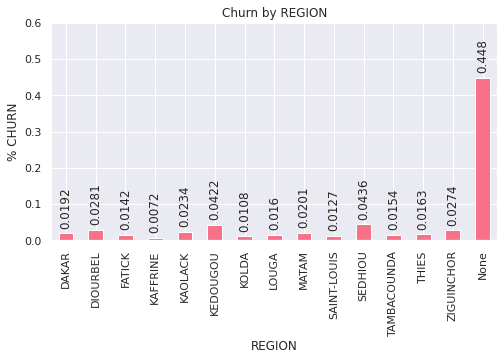

In [12]:
plot_categorical_by_target(df, 'REGION')

Those customers whose region is not known are very much more likely to churn. In addition we see that, for example, the churn rate in SEDHIOU is around 4 times greater than the churn rate in other regions like KAFFRINE and KOLDA, so this feature certainly has potential to be predictive. 

<u>__Data transformation tasks__</u>: 

- I create a function ```fill_region``` to fill the null values in REGION with 'UNKNOWN'.

In [13]:
def fill_region(df):
    '''Full null regions with UNKNOWN'''
    return df.fillna('UNKNOWN', subset='REGION')
df = df.transform(fill_region)

#### TENURE in detail

The entries for tenure are complete with no null values:

In [14]:
show_categorical(df, 'TENURE')

+-------------+-------+-----------+
|       TENURE| totals|percentages|
+-------------+-------+-----------+
| K > 24 month|2043201|     0.9485|
|I 18-21 month|  45278|      0.021|
|H 15-18 month|  26006|     0.0121|
|G 12-15 month|  14901|     0.0069|
|J 21-24 month|  12725|     0.0059|
| F 9-12 month|   9328|     0.0043|
|  E 6-9 month|   1839|     9.0E-4|
|  D 3-6 month|    770|     4.0E-4|
+-------------+-------+-----------+



Let's look at the relationship between TENURE and our target variable CHURN:

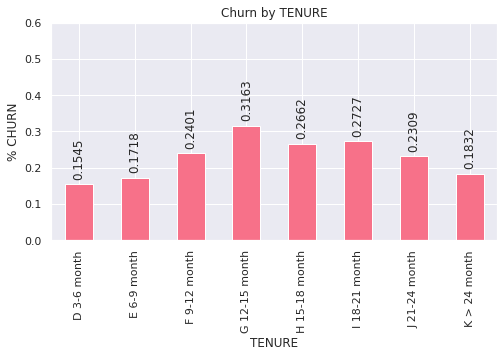

In [15]:
plot_categorical_by_target(df, 'TENURE')

This graph tells us that customers are most likely to churn around the 12-15-month point. Customers prior to this point churn less, and customers who have been with the company for more than 24 months appear to have become rather loyal and churn less - good news for Expresso since 95% of their customers have been with them for more than 24 months! It would seem TENURE could also be a useful variable for our model.

#### MRG in detail

It turns out MRG is a non-feature - all records contain the same value, so we'll drop this column:

In [16]:
show_categorical(df, 'MRG')

+---+-------+-----------+
|MRG| totals|percentages|
+---+-------+-----------+
| NO|2154048|        1.0|
+---+-------+-----------+



<u>__Data transformation tasks__</u>: 

- Below I start a list of ```columns_to_drop``` and create a function ```drop_columns``` to drop required columns. I'll add to this list as we go if required.

In [17]:
columns_to_drop = ['MRG']
def drop_columns(df, *columns):
    '''Drop columns identified as irrelevant or containing too many nulls'''
    return df.drop(*columns)
df = df.transform(lambda df: drop_columns(df, *columns_to_drop))

#### TOP_PACK in detail

TOP_PACK contains almost 42% null values. In addition we have more than 20 distinct values:

In [18]:
# Now let's examine TOP_PACK
show_categorical(df, 'TOP_PACK')

+--------------------+------+-----------+
|            TOP_PACK|totals|percentages|
+--------------------+------+-----------+
|                null|902594|      0.419|
|All-net 500F=2000...|317802|     0.1475|
|On net 200F=Unlim...|152295|     0.0707|
|    Data:490F=1GB,7d|115180|     0.0535|
|Data: 100 F=40MB,24H| 84649|     0.0393|
|Mixt 250F=Unlimit...| 67512|     0.0313|
|MIXT:500F= 2500F ...| 64412|     0.0299|
|  Data:1000F=2GB,30d| 59770|     0.0277|
|All-net 500F =200...| 46890|     0.0218|
|         Jokko_Daily| 45036|     0.0209|
|Data: 200 F=100MB...| 42841|     0.0199|
| IVR Echat_Daily_50F| 28658|     0.0133|
| On-net 500=4000,10d| 26733|     0.0124|
|  On-net 500F_FNF;3d| 22332|     0.0104|
|Data:200F=Unlimit...| 22043|     0.0102|
|MIXT: 200mnoff ne...| 19318|      0.009|
|On-net 1000F=10Mi...| 18454|     0.0086|
|VAS(IVR_Radio_Daily)| 14686|     0.0068|
|   Data:1000F=5GB,7d| 14629|     0.0068|
|  Twter_U2opia_Daily| 12060|     0.0056|
+--------------------+------+-----

Let's check how many distinct TOP_PACK values we have:

In [19]:
print(f'''Number of distinct values in TOP_PACK: {df[['TOP_PACK']].distinct().count()}''')

Number of distinct values in TOP_PACK: 141


With 141 different packages we would be hard-pressed to know which one of the 141 TOP_PACK values to impute into the nulls. Furthermore, to one-hot-encode 141 features would result in an explosion of features, and label encoding never seems like a good alternative for nominal variables as we run the risk of introducing some kind of implicit ordinal relationships which don't really exist (Brownlee, 2020).

<u>__Data transformation tasks__</u>: 

- For now I'm going to extend our list of ```columns_to_drop``` and drop TOP_PACK as well. We can always circle back and consider including this feature again later if required.

In [20]:
columns_to_drop.extend(['TOP_PACK'])
df = df.transform(lambda df: drop_columns(df, *columns_to_drop))

#### _Numeric variables_

Let's look at the numeric features next. In order to understand the scales of some of the numeric features, I established a few background facts:

- The Senegalese currency is the West African CFA franc (ISO 4217 code XOF) (Wikipedia, 2023)
- The average monthly wage in Q3 of 2023 was 106811 CFA, where the average monthly wage for a high-skilled employee was 382000 CFA (TAKE-PROFIT, 2023).
- Some examples of costs of Expresso packages include:
    - "1 GB, valid for 1 day for CFA 700...
    - 4 GB, valid for 30 days for CFA 2,000...
    - 50 GB, valid for 30 days for CFA 10,000" (Giroux, 2023)
    
From this information I was able to clarify for myself that when the English variable description reads 'monthly income of each client' it would be better translated as 'revenue received from each client' - it does not refer to the salary of the client!

_NOTE:_ In the interests of brevity I'll demonstrate my process on the first set of numeric variables MONTANT and FREQUENCE and summarize the rest of my numeric variable findings and data transformation tasks.

#### MONTANT and FREQUENCE_RECH in detail

MONTANT and FREQUENCE_RECH are related variables: MONTANT represents the top-up amount per client, and FREQUENCE_RECH represents the frequency of said top-ups. Both variables have exactly the same number of non-null entries (see 'count'):

In [21]:
vars_list = ['MONTANT', 'FREQUENCE_RECH']
df[vars_list].describe().show()

+-------+----------------+------------------+
|summary|         MONTANT|    FREQUENCE_RECH|
+-------+----------------+------------------+
|  count|         1397309|           1397309|
|   mean|5532.11699774352|11.529119901181485|
| stddev|7111.33942055855|13.274069546587215|
|    min|            10.0|               1.0|
|    max|        470000.0|             133.0|
+-------+----------------+------------------+



Let's look at the distribution of MONTANT and FREQUENCE_RECH. Both are right-skewed but MONTANT extremely so:

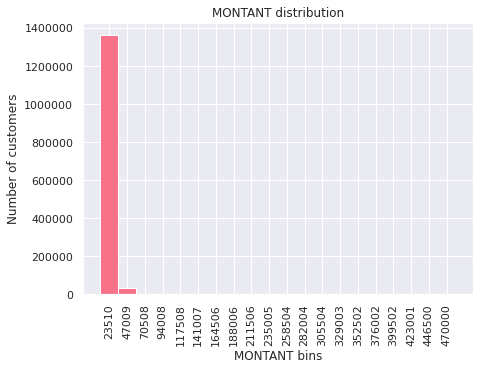

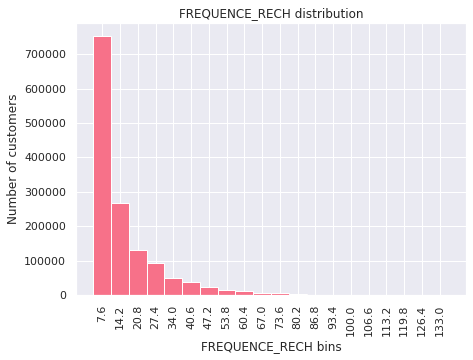

In [22]:
show_histogram(df, vars_list)

Because it has extreme outliers, the median will give us a better indication of the relationship between MONTANT, FREQUENCE_RECH and our target variable CHURN. Here we see that churners spent significantly less on topups compared to non-churners and also topped up more frequently, meaning both variables should have some predictive value for our model:

In [23]:
show_metric_by_target(df, vars_list)

+-----+--------------+
|CHURN|MONTANT_median|
+-----+--------------+
|  0.0|        3250.0|
|  1.0|        1000.0|
+-----+--------------+

+-----+---------------------+
|CHURN|FREQUENCE_RECH_median|
+-----+---------------------+
|  0.0|                  7.0|
|  1.0|                  2.0|
+-----+---------------------+



We already saw that 35% of customers have null values for MONTANT and FREQUENCE_RECH. According to my understanding of the concept of top-up in mobile services, it is something one may or may not need to do depending on the nature of the service you are subscribed to and your individual usage.

We are not given a timeframe for MONTANT and FREQUENCE_RECH so we can't know if these are all-time totals or numbers for a specific timeframe. However, given that the mean average monthly income of an individual is 106811 CFA (see above) we can certainly say that some of these amounts for MONTANT look extreme. The distribution graph above shows us most clients that top-up do so only up to 23510 CFA, with a very much smaller number topping up to 47009 CFA. Anything beyond this should be considered an outlier. Outliers can be problematic in machine learning models and there are several options for handling them, including dropping outlier records, or using IQR or z-score methods to reduce their effect (Jagdeesh, n.d.). However, my first go-to method will be to use a Robust Scaler (Apache Spark, 2023) on features like this because it scales 'features using statistics that are robust to outliers' (Scikit-Learn, 2023).

<u>__Data transformation tasks__</u>: 

- Because of the extreme outliers I will start a list of ```columns_to_scale``` at the end of the process and add MONTANT to it. 
- Fill null entries for both MONTANT and FREQUENCE_RECH with 0 on the assumption that in these scenarios the user did not need to top-up. I will start a list of ```columns_to_fill_zeros``` and a function ```fill_zeros``` to fill the required columns with 0.0's.

In [24]:
columns_to_scale = ['MONTANT']
columns_to_fill_zeros = ['MONTANT', 'FREQUENCE_RECH']
def fill_zeros(df, columns):
    '''Fill specified null values with 0'''
    return df.fillna(0.0, subset=columns)
df = df.transform(lambda df: fill_zeros(df, columns_to_fill_zeros))

#### Remaining numeric variables

Below are my findings on the remainder of the numeric variables:

__REVENUE, ARPU_SEGMENT & FREQUENCE__ are also related variables. All 3 data points are significantly lower for churners compared to non-churners, so these variables should have predictive value for our model.

__DATA_VOLUME__ represents the number of connections made. Churners have significantly fewer connections compared to non-churners.

__ON_NET, ORANGE, TIGO, ZONE1 & ZONE2__ are also related variables, representing calls made to different networks. ZONE1 & ZONE2 looked to have low numbers of data points and low predictive values, but calls to ON_NET, ORANGE and TIGO have predictive value with non-churners making significantly more calls than churners.

__REGULARITY__ represents the number of times a client is active for 90 days: unlike many of the other variables, it is not right-skewed and has no missing values - it can be used as-is.

__FREQ_TOP_PACK__ represents the number of times the client activated the top packages. Although we dropped the TOP_PACK column there is no reason why we shouldn't retain this data point as it also looks like it has predictive value.

<u>__Data transformation tasks__</u>: 

- The REVENUE, ARPU_SEGMENT, DATA_VOLUME, ON_NET, ORANGE, TIGO, FREQ_TOP_PACK distributions are all highly skewed so I will add these columns to our ```columns_to_scale``` list.
- I will extend ```columns_to_fill_zeros``` by adding REVENUE, ARPU_SEGMENT, FREQUENCE, DATA_VOLUME, ON_NET, ORANGE, TIGO, FREQ_TOP_PACK on the assumption that null values mean no activity took place from the customer.
- I will extend ```columns_to_drop``` by adding ZONE1 and ZONE2.

In [25]:
columns_to_scale.extend(['REVENUE', 'ARPU_SEGMENT', 'DATA_VOLUME', 
                         'ON_NET', 'ORANGE', 'TIGO', 'FREQ_TOP_PACK'])
columns_to_fill_zeros.extend(['REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 
                              'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 
                              'FREQ_TOP_PACK'])
columns_to_drop.extend(['ZONE1', 'ZONE2'])
df = df.transform(lambda df: fill_zeros(df, columns_to_fill_zeros))
df = df.transform(lambda df: drop_columns(df, *columns_to_drop))

Our dataset should now have all non-null values and only the columns we want to include:

In [26]:
df.agg(*[
       (fn.count(c)).alias(c + '_nonnulls')
       for c in df.columns
]).show(vertical = True)

-RECORD 0--------------------------
 user_id_nonnulls        | 2154048 
 REGION_nonnulls         | 2154048 
 TENURE_nonnulls         | 2154048 
 MONTANT_nonnulls        | 2154048 
 FREQUENCE_RECH_nonnulls | 2154048 
 REVENUE_nonnulls        | 2154048 
 ARPU_SEGMENT_nonnulls   | 2154048 
 FREQUENCE_nonnulls      | 2154048 
 DATA_VOLUME_nonnulls    | 2154048 
 ON_NET_nonnulls         | 2154048 
 ORANGE_nonnulls         | 2154048 
 TIGO_nonnulls           | 2154048 
 REGULARITY_nonnulls     | 2154048 
 FREQ_TOP_PACK_nonnulls  | 2154048 
 CHURN_nonnulls          | 2154048 



#### Correlation between variables

It is useful to get an idea of the correlations between each of our feature variables and our target variable CHURN. Not only can this information give us insights into feature selection (features that are highly correlated with the target variable may be particularly useful), but also some machine learning algorithms perform poorly when there is multicollinearity between feature variables.

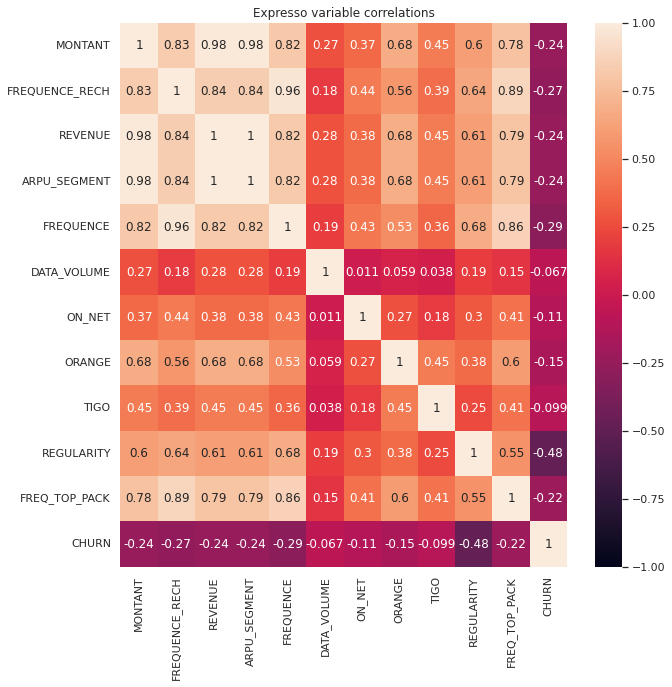

In [27]:
feats_for_corr = [c[0] for c in df.dtypes if c[1] == 'double']
assembler = VectorAssembler(inputCols=feats_for_corr, outputCol='feats_for_corr')
df_feats_for_corr = assembler.transform(df).select('feats_for_corr')

corr_matrix = Correlation.corr(df_feats_for_corr, 'feats_for_corr')
corr_matrix = corr_matrix.collect()[0]["pearson({})".format('feats_for_corr')].values.reshape(12, 12)

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, xticklabels=feats_for_corr, yticklabels=feats_for_corr, annot=True, vmin = -1, vmax = 1)
plt.title('Expresso variable correlations')
plt.show()

Above we can see the following are heavily correlated:

- REVENUE and ARPU_SEGMENT have 100% correlation!
- MONTANT and REVENUE as well as MONTANT and ARPU_SEGMENT have 98% correlation
- FREQUENCE and FREQUENCE_RECH are also high at 96%
- FREQUENCE_RECH and FREQ_TOP_PACK are fairly high at 0.89
- FREQUENCE and FREQ_TOP_PACK are also fairly high at 0.87

Some algorithms such as Random Forest or Gradient Boosting can handle multicollinearity among feature inputs but others like Logistic Regression perform less well so we need an option to be able to resolve the multicolinearities if required. There are a number of ways we can resolve multicollinearity issues: for now I will go with the simplest option which is to drop very highly correlated columns.

By the given definition ARPU_SEGMENT is the income (or revenue) over 90 days / 3 which is why it is so similar to REVENUE. I will therefore drop ARPU_SEGMENT. Before deciding on what to do about MONTANT and REVENUE I wondered whether we could determine if REVENUE _includes_ MONTANT (those top-up amounts) or not so I checked for instances where MONTANT was greater than REVENUE and found that there were instances in all tenure groups, but more especially in the > 24 month group:

In [28]:
spark.sql(f'''SELECT 
              TENURE
              , COUNT(*) AS totals
              FROM sql_table WHERE MONTANT > REVENUE
              GROUP BY 1 ORDER BY 1''').show()

+-------------+------+
|       TENURE|totals|
+-------------+------+
|  D 3-6 month|   301|
|  E 6-9 month|   586|
| F 9-12 month|  2200|
|G 12-15 month|  2821|
|H 15-18 month|  4877|
|I 18-21 month|  8639|
|J 21-24 month|  2379|
| K > 24 month|476004|
+-------------+------+



<u>__Data transformation tasks__</u>: 

- Clearly REVENUE does not include MONTANT. Because of this I decided that creating a new feature TOTAL_SPENT = REVENUE + MONTANT would be the best route to go in this instance, after which I can drop the original columns. This feature will also need to be scaled so add it to ```columns_to_scale```.
- I will drop the correlated columns FREQ_TOP_PACK and FREQUENCE_RECH and just retain FREQUENCE.
- These steps have been incorporated into the function ```resolve_mcollinear```

We may not need to take this step for all models, so I will create a new DataFrame ```df_limited``` so we retain the option of using the full dataset currently represented by ```df``` if desired.

In [29]:
columns_to_scale.extend(['TOTAL_SPENT'])
def resolve_mcollinear(df):
    '''Drop or combine columns to remove high multicollinearity'''
    return df.withColumn('TOTAL_SPENT', df['REVENUE'] + df['MONTANT']) \
             .drop('ARPU_SEGMENT', 'FREQ_TOP_PACK', 'FREQUENCE_RECH', 'REVENUE', 'MONTANT')
df_limited = df.transform(resolve_mcollinear)

We now have 2 possible datasets we can use as inputs to our models: the full dataset with all columns we decided to include, and the limited dataset where highly correlated columns have been dropped:

In [30]:
print('Full dataset (df):')
df.printSchema()
print('Limited dataset (df_limited):')
df_limited.printSchema()

Full dataset (df):
root
 |-- user_id: string (nullable = true)
 |-- REGION: string (nullable = false)
 |-- TENURE: string (nullable = true)
 |-- MONTANT: double (nullable = false)
 |-- FREQUENCE_RECH: double (nullable = false)
 |-- REVENUE: double (nullable = false)
 |-- ARPU_SEGMENT: double (nullable = false)
 |-- FREQUENCE: double (nullable = false)
 |-- DATA_VOLUME: double (nullable = false)
 |-- ON_NET: double (nullable = false)
 |-- ORANGE: double (nullable = false)
 |-- TIGO: double (nullable = false)
 |-- REGULARITY: double (nullable = true)
 |-- FREQ_TOP_PACK: double (nullable = false)
 |-- CHURN: double (nullable = true)

Limited dataset (df_limited):
root
 |-- user_id: string (nullable = true)
 |-- REGION: string (nullable = false)
 |-- TENURE: string (nullable = true)
 |-- FREQUENCE: double (nullable = false)
 |-- DATA_VOLUME: double (nullable = false)
 |-- ON_NET: double (nullable = false)
 |-- ORANGE: double (nullable = false)
 |-- TIGO: double (nullable = false)
 |-- REGU

## 1.3 Hypothesis

Given what we have seen above, each of the feature variables has a reasonable degree of correlation with the target, with REGULARITY being the most correlated at -0.48. Building a model to predict whether a customer will churn or not  looks feasible. In the following section I will investigate which models and combinations of parameters work best on this dataset and select a final model that we could look at productionizing.

## 1.4 Planned analysis

I will be evaluating 3 binary classification models: LogisticRegression, RandomForestClassifier and GBTClassifier. To do so I will:

1. Draw a sample of our data to be used for model evaluation
2. Handle basic data transformation tasks as described above
3. Build a pipeline to handle data preparation
4. Implement cross-validation on a sample of our dataset to evaluate the  results of different models and combinations of hyperparameters
5. Select the best model and train on the full dataset to get our final estimator
6. Use the resulting model - our final transformer - to predict on a hold-out test set and evaluate

# 2. Implementation

To demonstrate the complete process I will read in the data from scratch and then proceed with the steps outlined above.

## 2.1 Train/test splits

First we want to use cross-validation to help us select the best model and model parameters. Cross-validation runtimes can be prohibitively long on a large dataset since each algorithm and hyperparmeter combination is fitted and evaluated multiple times. This makes it a much more reliable estimator of actual performance but also means that it may take a long time to run to completion. To mitigate against this I will be using a sample of my dataset for the evaluation phase, and will only use the full training set to train the final model, and then of course the holdout test set at the end for final evaluation of performance. The data will be split as follows:

![Train-Test Splits](train-test-splits.png)

Below we can see that the class imbalance is preserved at each split:

In [31]:
# Read in our df
df = spark.read.csv("hdfs://lena/user/<username>/coursework2/expresso_train.csv", inferSchema = True, header= True)
print('Original class ratios (100% of data):')
show_categorical(df, 'CHURN')

# Split df into train_df and test_df
train_df, test_df = df.randomSplit([0.7,0.3])
print('train_df class ratios (70% of df):')
show_categorical(train_df, 'CHURN')
print('test_df class ratios (30% of df):')
show_categorical(test_df, 'CHURN')

# Sample from train_df to get a reduced dataset for model selection
sample = train_df.sample(fraction=0.6, seed=42)
print('Sample class ratios (60% of train_df):')
show_categorical(sample, 'CHURN')

# Split sample into train_sample and test_sample
train_sample, test_sample = sample.randomSplit([0.7,0.3])
print(f'''train_sample class ratios (70% of sample):
({round(train_sample.count() / df.count(), 2) * 100}% of data to be used for model selection)''')
show_categorical(train_sample, 'CHURN')
print('test_sample class ratios (30% of sample):')
show_categorical(test_sample, 'CHURN')

Original class ratios (100% of data):
+-----+-------+-----------+
|CHURN| totals|percentages|
+-----+-------+-----------+
|    0|1750062|     0.8125|
|    1| 403986|     0.1875|
+-----+-------+-----------+

train_df class ratios (70% of df):
+-----+-------+-----------+
|CHURN| totals|percentages|
+-----+-------+-----------+
|    0|1224250|     0.8123|
|    1| 282835|     0.1877|
+-----+-------+-----------+

test_df class ratios (30% of df):
+-----+------+-----------+
|CHURN|totals|percentages|
+-----+------+-----------+
|    0|525812|     0.8127|
|    1|121151|     0.1873|
+-----+------+-----------+

Sample class ratios (60% of train_df):
+-----+------+-----------+
|CHURN|totals|percentages|
+-----+------+-----------+
|    0|735268|     0.8124|
|    1|169801|     0.1876|
+-----+------+-----------+

train_sample class ratios (70% of sample):
(28.999999999999996% of data to be used for model selection)
+-----+------+-----------+
|CHURN|totals|percentages|
+-----+------+-----------+
|    

## 2.2 Data transformations

As a reminder, the following lists and functions were defined in the process above:

In [32]:
for listicle in [('doubles', doubles), 
                 ('columns_to_drop', columns_to_drop), 
                 ('columns_to_fill_zeros', columns_to_fill_zeros), 
                 ('columns_to_scale', columns_to_scale)]:
    print(f'''{listicle[0]} = ''')
    pprint(listicle[1], compact = True)
print('\n')
for functions in [cast_to_double, fill_region, drop_columns, fill_zeros, resolve_mcollinear]:
    definitions = inspect.getsource(cast_to_double)
    print(definitions)

doubles = 
['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE',
 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2', 'REGULARITY',
 'FREQ_TOP_PACK', 'CHURN']
columns_to_drop = 
['MRG', 'TOP_PACK', 'ZONE1', 'ZONE2']
columns_to_fill_zeros = 
['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE',
 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'FREQ_TOP_PACK']
columns_to_scale = 
['MONTANT', 'REVENUE', 'ARPU_SEGMENT', 'DATA_VOLUME', 'ON_NET', 'ORANGE',
 'TIGO', 'FREQ_TOP_PACK', 'TOTAL_SPENT']


def cast_to_double(df, columns):
    '''Transform required columns to double type'''
    return df.select(
                *(c for c in df.columns if c not in columns),
                *(fn.col(c).cast('double').alias(c) for c in columns)
               )

def cast_to_double(df, columns):
    '''Transform required columns to double type'''
    return df.select(
                *(c for c in df.columns if c not in columns),
                *(fn.col(c).cast('double

In the interests of time I will use the version of our dataset that resolves multicollinearity issues to test all 3 models. In practice one would want to test both versions with RandomForest and GBTClassifier (which can tolerate multicollinearity) to see if one performs better than the other. Let's run the data transformation functions on the sampled train and test sets:

In [33]:
# Train transformation
train_sample = (train_sample.transform(lambda df: cast_to_double(df, doubles))
                .transform(lambda df: fill_region(df))
                .transform(lambda df: drop_columns(df, *columns_to_drop))
                .transform(lambda df: fill_zeros(df, columns_to_fill_zeros))
                .transform(lambda df: resolve_mcollinear(df))
                  )

# Test transformation
test_sample = (test_sample.transform(lambda df: cast_to_double(df, doubles))
                .transform(lambda df: fill_region(df))
                .transform(lambda df: drop_columns(df, *columns_to_drop))
                .transform(lambda df: fill_zeros(df, columns_to_fill_zeros))
                .transform(lambda df: resolve_mcollinear(df))
                  )

## 2.3 Data preparation pipeline

<u>__Outliers__</u>:

Logistic regression assumes no extreme outliers (Zach, 2020). However, Random forest and Gradient boosting can also be sensitive to outliers (user603, 2015), (Zottie, 2016) so for all our models I will use the RobustScaler to reduce their effect as discussed previously.

<u>__Ranges__</u>:

Different features in our dataset have different ranges: for example number of connections were relatively smaller numbers compared with revenue which is measured in currency. It is best practice to scale all features to be in the same range so that each feature can contribute equally to the model. I will use the MinMaxScaler on all numeric features (Apache Spark, 2023). This will ensure that all feature values fall between 0 and 1.

<u>__One-hot-encoding__</u>:

All of our categorical features are nominal rather than ordinal so this is the most approprate choice.

Our data preparation pipeline should therefore cater for the following:

1. One-hot-encode categorical features
2. Perform robust scaling on highly skewed features identified above
3. Perform minmax scaling on all numeric features 
4. Assemble final vector of features

In [34]:
def assemble_data_pipeline(df, columns_to_scale = columns_to_scale):
    '''Takes in one of the df variants and the list of columns to scale, 
    and sets up the pipeline stages to do data transformation'''
    oh_columns = [c[0] for c in df.dtypes if c[1] == 'string' and c[0] != 'user_id']
    db_columns = [c[0] for c in df.dtypes if c[1] == 'double' and c[0] != 'user_id']
    sc_columns = [c[0] for c in df.dtypes if c[1] == 'double' and c[0] in columns_to_scale]
    nm_columns = [c for c in db_columns if c not in sc_columns and c!= 'CHURN']
    
    stages = [] 
    
    # Perform one-hot encoding on categorical features
    for c in oh_columns:
        indexer = StringIndexer(inputCol=c, outputCol=c + '_ind')
        encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], \
                outputCols=[c + '_oh'])    
        stages += [indexer, encoder] 
    
    # Assemble a vector of features that require robust scaler
    sc_assembler = VectorAssembler(inputCols=sc_columns, outputCol='sc_features')
    stages += [sc_assembler]

    # Perform robust scaling
    robust_scaler = RobustScaler(inputCol='sc_features', outputCol = 'robust_features')
    stages +=[robust_scaler]

    # Assemble a vector of the rest of the numeric features that don't require robust scaler
    nm_assembler = VectorAssembler(inputCols=nm_columns, outputCol='nm_features')
    stages += [nm_assembler]

    # For all numeric features do minmax scaling
    for c in ['robust_features', 'nm_features']:
        minmax_scaler = MinMaxScaler(min=0.0, max=1.0, inputCol=c, outputCol=c + '_minmax')
        stages += [minmax_scaler]
    
    # Assemble a vector of our final features
    finalizer = VectorAssembler(inputCols=['robust_features_minmax', 'nm_features_minmax', 'REGION_oh','TENURE_oh'],
                                outputCol='final_features')
    stages += [finalizer]

    return Pipeline(stages=stages)

In [35]:
# Get vectorized features and label for sample
sample_pipeline = assemble_data_pipeline(train_sample)
sample_estimator = sample_pipeline.fit(train_sample)
train_sample_features = sample_estimator.transform(train_sample).select(['user_id', 'final_features', 'CHURN'])
test_sample_features = sample_estimator.transform(test_sample).select(['user_id', 'final_features', 'CHURN'])
train_sample_features.show(1)

+--------------------+--------------------+-----+
|             user_id|      final_features|CHURN|
+--------------------+--------------------+-----+
|00000cb4a5d760de8...|(28,[6,7,22],[0.0...|  1.0|
+--------------------+--------------------+-----+
only showing top 1 row



## 2.4 Cross-validation and model evaluation

In this section I will use ParamGridBuilder to define a hyperparameter search space for each model. I will then use the CrossValidator to iterate through the hyperparameter space, and determine the best model, based on our chosen metric areaUnderROC. In a real-world situation one would explore the space quite widely, however, in the interests of time I will only experiment with a small number of options for each model to illustrate the process. 

LogisticRegression's performance was quite fast so I searched a slightly wider space. The RandomForestClassifier was relatively slower, and the GBTClassifier even slower, so I have only defined a small search space for each of these.

First let's setup a binary classification evaluator. I have selected areaUnderROC as our evaluation metric:

In [36]:
evaluator = BinaryClassificationEvaluator(labelCol='CHURN', 
                                          rawPredictionCol='rawPrediction', 
                                          metricName='areaUnderROC')

I tested cross-validation runtimes with and without persisting ```train_sample_features```, and persisting resulted in a good improvement (see 2.4.4 Model selection for details) so I will do that before we begin. Note the __persist()__ method, unlike __cache()__, lets you specify a storage level but the default used here is both memory and disk (Apache Spark 2023). It is useful in the situation of cross-validation because the same dataframe will need to be accessed repeatedly and this will be faster if it is already in memory.

In [37]:
train_sample_features.persist()

DataFrame[user_id: string, final_features: vector, CHURN: double]

### 2.4.1 LogisticRegression

LogisticRegression is "the benchmark model for classification. The logistic regression uses a logit function to calculate the probability of an observation belonging to a particular class"  (Drabas & Lee, 2017, p. 101). Binomial logistic regression is used with a binary target variable e.g. churn / not churn (McDonald, 2014, p. 250). I will test LogisticRegression with different values of ```maxIter``` (maximum number of iterations after which to stop if convergence was not reached) and ```regParam``` (or regularization parameter which can be tuned to prevent overfitting). The other commonly tuned parameter is ```elasticNetParam``` which is a mixing parameter where 0 = L2 penalty and 1 = L1 penalty (Apache Spark, 2023), but here I will be using the default. 

The hyperparameter search space is a reduced subset of the suggestions from Sparkitecture (Ford, 2019).

\[NOTE: To marker - to run a small subset more quickly, use the alternate ```lr_searchspace``` under the comment __# Reduced searchspace__]

In [38]:
# Instantiate the model
lr = LogisticRegression(featuresCol='final_features',labelCol='CHURN')

lr_searchspace = {'maxIter': [5, 10, 20],
                  'regParam': [0.01, 0.1, 0.5, 1.0]}
# Reduced searchspace
# lr_searchspace = {'maxIter': [10],
#                   'regParam': [0.01]}
lr_combinations = len(list(itertools.product(*lr_searchspace.values())))

# Setup the parameter grid
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.maxIter, lr_searchspace['maxIter'])
                 .addGrid(lr.regParam, lr_searchspace['regParam'])
                 .build())

# Instantiate cross-validation
lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator,
                       numFolds=3,
                       seed=8,
                       collectSubModels=True,
                       parallelism = 2)

# Run cross validation
start_time = time.time()
lr_cv_model = lr_cv.fit(train_sample_features)
lr_run_time = round(time.time() - start_time, 4)

# Display time metrics
print(f'''Cross-validation performance using LogisticRegression:
------------------------------------------------------
searchspace:       {lr_combinations} combinations 
runtime:           {lr_run_time} seconds
mean runtime:      {round(lr_run_time / lr_combinations, 4)} seconds''')

# Display performance metrics
best_lr_model = lr_cv_model.bestModel
auc_lr = evaluator.evaluate(lr_cv_model.transform(test_sample_features))
print(f'''
Best model metrics using LogisticRegression:
------------------------------------------------------
maxIter:           {best_lr_model.getMaxIter()}
regParam:          {best_lr_model.getRegParam()}
elasticNetParam:   {best_lr_model.getElasticNetParam()}
areaUnderROC:      {round(auc_lr, 4)}''')

Cross-validation performance using LogisticRegression:
------------------------------------------------------
searchspace:       12 combinations 
runtime:           131.8593 seconds
mean runtime:      10.9883 seconds

Best model metrics using LogisticRegression:
------------------------------------------------------
maxIter:           10
regParam:          0.01
elasticNetParam:   0.0
areaUnderROC:      0.9264


### 2.4.2 RandomForestClassifier

The RandomForestClassifier "produces multiple decision trees (hence the name—forest) and uses the mode output of those decision trees to classify observations" (Drabas & Lee, 2017, p. 102). I will test RandomForestClassifier with different values of ```numTrees``` (number of trees to train), ```maxDepth``` (maximum depth for trees) which are the 2 most commonly tuned hyperparameters of RandomForest (Apache Spark, 2023). 

The hyperparameter search space is again a reduced subset of the suggestions from Sparkitecture (Ford, 2019).

\[NOTE: To marker - to run a small subset more quickly, use the alternate ```rf_searchspace``` under the comment __# Reduced searchspace__]

In [39]:
# Instantiate the model
rf = RandomForestClassifier(featuresCol='final_features',labelCol='CHURN')

rf_searchspace = {'numTrees': [10, 20],
                  'maxDepth': [5, 10, 15]}
# Reduced searchspace
# rf_searchspace = {'numTrees': [20],
#                   'maxDepth': [15]}
rf_combinations = len(list(itertools.product(*rf_searchspace.values())))

# Setup the parameter grid
rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, rf_searchspace['numTrees'])
                 .addGrid(rf.maxDepth, rf_searchspace['maxDepth'])
                 .build())

# Instantiate cross-validation
rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       numFolds=3,
                       seed=8,
                       collectSubModels=True,
                       parallelism = 2)

# Run cross validation
start_time = time.time()
rf_cv_model = rf_cv.fit(train_sample_features)
rf_run_time = round(time.time() - start_time, 4)

# Display time metrics
print(f'''Cross-validation performance using RandomForest:
------------------------------------------------------
searchspace:       {rf_combinations} combinations 
runtime:           {rf_run_time} seconds
mean runtime:      {round(rf_run_time / rf_combinations, 4)} seconds''')

# Display performance metrics
best_rf_model = rf_cv_model.bestModel
auc_rf = evaluator.evaluate(rf_cv_model.transform(test_sample_features))
print(f'''
Best model metrics using RandomForest:
------------------------------------------------------
numTrees:          {best_rf_model.getNumTrees}
maxDepth:          {best_rf_model.getMaxDepth()}
areaUnderROC:      {round(auc_rf, 4)}''')

Cross-validation performance using RandomForest:
------------------------------------------------------
searchspace:       6 combinations 
runtime:           286.7742 seconds
mean runtime:      47.7957 seconds

Best model metrics using RandomForest:
------------------------------------------------------
numTrees:          20
maxDepth:          15
areaUnderROC:      0.9289


### 2.4.2 GBTClassifier

The GBTClassifier is a "Gradient Boosted Trees model for classification. The model belongs to the family of ensemble models: models that combine multiple weak predictive models to form a strong one" (Drabas & Lee, 2017, p. 102). I will test the GBTClassifier with different values of ```maxIter``` ((maximum number of iterations after which to stop if convergence was not reached)), ```maxDepth``` (maximum depth for trees) which are the 2 most fundamental hyperparameters of the GBTClassifier (Apache Spark, 2023). 

The hyperparameter search space is again a reduced subset of the suggestions from Sparkitecture (Ford, 2019).

\[NOTE: To marker - to run a small subset more quickly, use the alternate ```gb_searchspace``` under the comment __# Reduced searchspace__]

In [40]:
# Instantiate the model
gb = GBTClassifier(featuresCol='final_features',labelCol='CHURN')

gb_searchspace = {'maxIter': [10, 20],
                  'maxDepth': [5, 10]}
# Reduced searchspace
# gb_searchspace = {'maxIter': [20],
#                   'maxDepth': [5]}
gb_combinations = len(list(itertools.product(*gb_searchspace.values())))

# Setup the parameter grid
gb_param_grid = (ParamGridBuilder()
                 .addGrid(gb.maxIter, gb_searchspace['maxIter'])
                 .addGrid(gb.maxDepth, gb_searchspace['maxDepth'])
                 .build())

# Instantiate cross-validation
gb_cv = CrossValidator(estimator=gb,
                       estimatorParamMaps=gb_param_grid,
                       evaluator=evaluator,
                       numFolds=3,
                       seed=8,
                       collectSubModels=True,
                       parallelism = 2)


# Run cross validation
start_time = time.time()
gb_cv_model = gb_cv.fit(train_sample_features)
gb_run_time = round(time.time() - start_time, 4)

# Display time metrics
print(f'''Cross-validation performance using GBTClassifier:
------------------------------------------------------
searchspace:       {gb_combinations} combinations 
runtime:           {gb_run_time} seconds
mean runtime:      {round(gb_run_time / gb_combinations, 4)} seconds''')

# Display performance metrics
best_gb_model = gb_cv_model.bestModel
auc_gb = evaluator.evaluate(gb_cv_model.transform(test_sample_features))
print(f'''
Best model metrics using GBTClassifier:
------------------------------------------------------
maxIter:           {best_gb_model.getMaxIter()}
maxDepth:          {best_gb_model.getMaxDepth()}
areaUnderROC:      {round(auc_gb, 4)}''')

Cross-validation performance using GBTClassifier:
------------------------------------------------------
searchspace:       4 combinations 
runtime:           299.1402 seconds
mean runtime:      74.785 seconds

Best model metrics using GBTClassifier:
------------------------------------------------------
maxIter:           20
maxDepth:          5
areaUnderROC:      0.9309


In [41]:
# Unpersist train_sample_features once we're done with it
train_sample_features.unpersist()

DataFrame[user_id: string, final_features: vector, CHURN: double]

### 2.4.4 Model selection

Following is a summary of the performance metrics obtained:

| Model | Mean Runtime | areaUnderROC |
| --- | --- | --- |
| LogisticRegression | 10.9883 seconds | 0.9264 |
| RandomForestClassifier | 47.7957 seconds | 0.9289 |
| GBTClassifier | 74.7850 seconds | 0.9309 |

From the above we can see that in terms of our metric areaUnderROC, all 3 models produced results that were very similar. However LogisticRegression is considerably faster. In business this is often a powerful deciding factor, both because of cost implications and in terms of the capacity to train and predict on a fast turnaround if required. For this reason I am selecting LogisticRegression as my final model of choice, even though (but only by a small margin) it had the lowest areaUnderROC.

As a matter of interest the Mean Runtimes without persisting the training dataframe were 15.6356 seconds, 67.3880 seconds and 105.1097 seconds respectively - this simple performance measure made a significant difference, and would definitely be recommended if we were to do a wider exploration of hyperparameters and/or use a larger training set.

## 2.5 Training and evaluating the final model

Our final step is to train our chosen model on the full training dataset and test it on the holdout test set. This will tell us whether cross-validation on a sample of our data was representative enough of the problem as a whole. If it was we should expect a similar areaUnderROC on the holdout test set.

First let's prepare our data:

In [42]:
# Run transformation functions on the sampled train and test sets
train_full = (train_df.transform(lambda df: cast_to_double(df, doubles))
                      .transform(lambda df: fill_region(df))
                      .transform(lambda df: drop_columns(df, *columns_to_drop))
                      .transform(lambda df: fill_zeros(df, columns_to_fill_zeros))
                      .transform(lambda df: resolve_mcollinear(df)))

# Run transformation functions
test_full = (test_df.transform(lambda df: cast_to_double(df, doubles))
                    .transform(lambda df: fill_region(df))
                    .transform(lambda df: drop_columns(df, *columns_to_drop))
                    .transform(lambda df: fill_zeros(df, columns_to_fill_zeros))
                    .transform(lambda df: resolve_mcollinear(df)))

# Get vectorized features and labels and persist train_full
final_pipeline = assemble_data_pipeline(train_full)
final_estimator = final_pipeline.fit(train_full)
train_features = final_estimator.transform(train_full).select(['user_id', 'final_features', 'CHURN'])
train_features.persist()
test_features = final_estimator.transform(test_full).select(['user_id', 'final_features', 'CHURN'])

Now we can train the final model and generate predictions on the holdout test set:

In [43]:
final_lr = LogisticRegression(featuresCol='final_features',
                              labelCol='CHURN',
                              maxIter = best_lr_model.getMaxIter(),
                              regParam = best_lr_model.getRegParam(),
                              elasticNetParam = best_lr_model.getElasticNetParam())

final_lr_model = final_lr.fit(train_features)
train_features.unpersist()

predictions = final_lr_model.transform(test_features)

The final areaUnderROC is 0.9255 which is very similar to the metric obtained via cross-validation (0.9264).

In [44]:
print(f'''areaUnderROC on hold-out test set:  {round(evaluator.evaluate(predictions), 4)}''')

areaUnderROC on hold-out test set:  0.9255


# 3. Summary and conclusions

My project explored predicting customer churn using PySpark machine learning models. This included:

- Data exploration
- Data transformation
- Setting up a pipeline to handle data preparation
- Using cross-validation to explore 3 different models, each with a limited set of hyperparameters
- Performing final model training, prediction on a test set, and evaluation

With a background in using Scikit-Learn, making the transition to PySpark was fairly straightforward. The biggest challenge was looking at how to get the best performance I could. With 'small data' one can often get away with using sub-optimal methods, where with 'big data' on PySpark performance can be startlingly improved by doing a task in a recommended, optimized way. The first example I encountered was during the exploratory data analysis phase: I was originally using a nested for-loop to get my correlation matrix and it took nearly 5 minutes to run! Having discovered that pyspark.ml.stat has a Correlation class I was able to achieve the same result in a few seconds.


## 3.1 Metrics evaluation

Because our final areaUnderROC was very similar to that obtained during cross-validation, we've been able to confirm that performing cross-validation on only a _sampled subset_ of the data with just 3-fold cross validation was sufficient to establish a decent set of hyperparameters to use in training the full dataset.

This is good news from a performance point of view: it gives us scope to widen the hyperparameter search space to find potentially better hyperparameter combinations while keeping runtimes reasonably fast since we are only using 29% of the full dataset to conduct this search.

On the surface, areaUnderROC looks like a good result, but to help us understand the results better let us look at the confusion matrix of predictions:

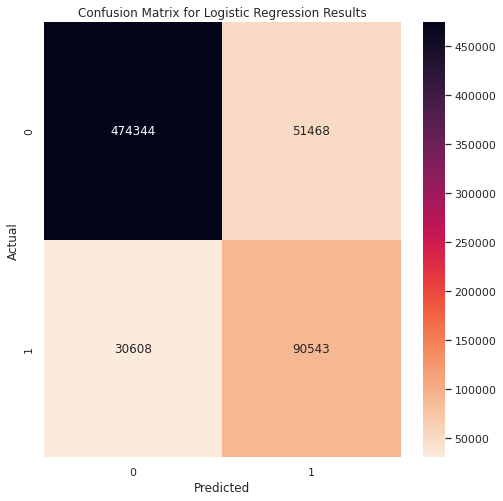

In [45]:
metrics = MulticlassMetrics(predictions.select(['prediction', 'CHURN']).rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, xticklabels=[0,1], yticklabels=[0,1], annot=True, fmt='g', cmap = 'rocket_r')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Results')
plt.show()

Above we see that 90543 true positives were picked up (we predicted 1 and CHURN was 1), but there are also 51468 false positives (we predicted 1 but CHURN was 0) and 30608 false negatives (we predicted 0 but CHURN was 1). 

From the confusion matrix we can calculate some additional metrics:

__Precision__: $\dfrac{TP}{TP+FP} = \dfrac{90543}{90543+51468} = 0.6376$<p>
__Recall__: $\dfrac{TP}{TP+FN} = \dfrac{90543}{90543+30608} =0.7474$<p>
__F-score__: $2 × \dfrac{precision × recall}{precision + recall} = 2 × \dfrac{0.6376 × 0.7474}{0.6376 + 0.7474} = 0.6881$
    
In business there is often a trade-off between Precision and Recall: Wikipedia summarizes "Precision can be seen as a measure of quality, and recall as a measure of quantity. Higher precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results (whether or not irrelevant ones are also returned)" (2023). In other words if business decides, for example, that it is important to identify as many churners as possible (even if that means including some customers that do not ultimately churn), then Recall will be prioritised as a metric.
    
In such a case we may want to look at adjusting the threshold parameter for LogisticRegression. The default threshold is 0.5, in other words all customers with a probability >= 0.5 will be categorised as CHURN. We could shift this, for example, to 0.45, meaning more customers would be predicted as CHURN. This is a parameter which can be included in hyperparameter tuning in the cross-validation phase OR adjusted as a post-processing step.

In [46]:
# Prepare data on false negatives and false positives
predictions = predictions.withColumn('probabilities', vector_to_array('probability'))
predictions = predictions.withColumn('proba_1', fn.col("probabilities")[1] )
FN = predictions.filter('CHURN = 1 AND prediction = 0').select(['CHURN', 'prediction', 'proba_1'])
FP = predictions.filter('CHURN = 0 AND prediction = 1').select(['CHURN', 'prediction', 'proba_1'])

Below we can see that the mean probability of the false negatives is 0.29:

In [47]:
print('False Negatives Mean Probability:')
show_metric_by_target(FN, ['proba_1'], 'mean')

False Negatives Mean Probability:
+-----+-------------------+
|CHURN|       proba_1_mean|
+-----+-------------------+
|  1.0|0.29161086834349975|
+-----+-------------------+



While the mean probability of the false positives is 0.55:

In [48]:
print('False Positives Mean Probability:')
show_metric_by_target(FP, ['proba_1'], 'mean')

False Positives Mean Probability:
+-----+------------------+
|CHURN|      proba_1_mean|
+-----+------------------+
|  0.0|0.5590774505390965|
+-----+------------------+



This information can give us further insights into how to adjust the threshold probability to include the customers according to business priorities.

## 3.2 Performance evaluation

The whole notebook took around 18 minutes to run. This is tolerably fast for processing 2,154,048 records, testing 3 different models, each with a selection of hyperparameters (albeit a very limited exploration).

The biggest gain in performance that I obtained was by __persisting__ the training set prior to cross-validation and training so that it could be read from memory during the many iterations of cross-validation. This reduced my cross-validation times by 29% on average.

I also read that cross-validation "parameter evaluation can be done in parallel by setting __parallelism__ with a value of 2 or more (a value of 1 will be serial) before running model selection with CrossValidator" (Apache Spark, 2023). I used the parameter (cautiously with a value of 2) and it resulted in only modest gains in performance - the same documentation also warned about "exceeding cluster resources" which is why I left it at 2, but it's possible had I gone with a higher value I could have seen a bigger improvement.

You will also notice that the entire DataFrame (which we read in at the beginning) is stored in just 2 __partitions__ (which makes sense given that the dataset is 247Mb it fits on 2 x 128Mb partitions. I also read that using a larger number of smaller partitions could improve performance (Shaya, 2023) and experimented with repartitioning my data into 4 partitions, but the runtimes were very similar so I went with the default of 2 partitions in the end.

In a recent benchmarking paper Garate-Escamilla, et al. looked at performance of logistic regression and random forest with increasing amounts of data (on 4 and 8 cores) and concluded "Time increases linearly as the length of the dataset’s growth, indicating the expected behavior of all models with respect to scalability. In addition, the scalability factor of each model when the length of time increases multiplying by 2, 4, 8, and 16, is less than 2, which implies that is better than a linear scalability " (2019). I would therefore expect PySpark to be able to handle much larger datasets than our current Expresso dataset if we wanted to scale up. 

It would be as well to experiment with the above parameters in the new situation to get optimal performance. One must also bear in mind that the longest-running component is cross-validation which is a once-off 'cost'. Training using the chosen hyperparameters, and prediction, which would take place regularly in a business setting, are very much quicker to run.

In [49]:
notebook_end = time.time()
print(f'''Notebook runtime:  {round(notebook_end - notebook_start, 4)} seconds''')

Notebook runtime:  1133.0277 seconds


In [50]:
sc.stop()

# References

Zindi, 2021. Expresso Churn Prediction Challenge. [Online] 
Available at: https://zindi.africa/competitions/expresso-churn-prediction
[Accessed 2023].

Apache Spark, 2023. pyspark.ml package¶. [Online] 
Available at: https://spark.apache.org/docs/3.0.1/api/python/pyspark.ml.html
[Accessed 2023].

Atabong, A. B., 2023. Outrage as Senegal cuts internet access for the second time. [Online] 
Available at: https://itweb.africa/content/j5alrMQAEXYMpYQk
[Accessed 2023].

Brownlee, J., 2020. Ordinal and One-Hot Encodings for Categorical Data. [Online] 
Available at: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
[Accessed 2023].

Wikipedia, 2023. West African CFA franc. [Online] 
Available at: https://en.wikipedia.org/w/index.php?title=West_African_CFA_franc&oldid=1169350917
[Accessed 2023].

TAKE-PROFIT, 2023. SENEGAL WAGES: MINIMUM AND AVERAGE. [Online] 
Available at: https://take-profit.org/en/statistics/wages/senegal/#:~:text=What%20is%20average%20wage%20in,minimum%20was%2073076%20CFA%2FMonth.
[Accessed 2023].

Giroux, M., 2023. Senegal SIM Cards: Everything You Need To Know. [Online] 
Available at: https://abrokenbackpack.com/senegal-sim-cards/
[Accessed 2023].

Jagdeesh, n.d. PySpark Outlier Detection and Treatment – A Comprehensive Guide How to handle Outlier in PySpark. [Online] 
Available at: https://www.machinelearningplus.com/pyspark/pyspark-outlier-detection-and-treatment/
[Accessed 2023].

Apache Spark, 2023. RobustScaler. [Online] 
Available at: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.RobustScaler.html
[Accessed 2023].

Scikit Learn, 2023. sklearn.preprocessing.RobustScaler¶. [Online] 
Available at: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
[Accessed 2023].

Zach, 2020. The 6 Assumptions of Logistic Regression (With Examples). [Online] 
Available at: https://www.statology.org/assumptions-of-logistic-regression/
[Accessed 2023].

user603, 2015. How are Random Forests not sensitive to outliers?. [Online] 
Available at: https://stats.stackexchange.com/questions/187200/how-are-random-forests-not-sensitive-to-outliers
[Accessed 2023].

Zottie, R., 2016. why boosting method is sensitive to outliers. [Online] 
Available at: https://stats.stackexchange.com/questions/140215/why-boosting-method-is-sensitive-to-outliers
[Accessed 2023].

Apache Spark, 2023. MinMaxScaler. [Online] 
Available at: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.MinMaxScaler.html#pyspark.ml.feature.MinMaxScaler
[Accessed 2023].

Apache Spark, 2023. pyspark.sql.DataFrame.persist. [Online] 
Available at: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.persist.html
[Accessed 2023].

Drabas, T. & Lee, D., 2017. Learning PySpark. Birmingham: Packt Publishing Ltd..
McDonald, J. H., 2014. Handbook of Biological Statistics. 3rd Edition ed. Baltimore: Sparky House Publishing.
Apache Spark, 2023. Logistic Regression. [Online] 
Available at: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html#pyspark.ml.classification.LogisticRegression
[Accessed 2023].

Ford, C. T., 2019. Logistic Regression. [Online] 
Available at: https://www.sparkitecture.io/machine-learning/classification/logistic-regression
[Accessed 2023].

Apache Spark, 2023. RandomForestClassifier. [Online] 
Available at: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html#pyspark.ml.classification.RandomForestClassifier
[Accessed 2023].

Ford, C. T., 2019. Random Forest. [Online] 
Available at: https://www.sparkitecture.io/machine-learning/classification/random-forest
[Accessed 2023].

Apache Spark, 2023. GBTClassifier. [Online] 
Available at: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html#pyspark.ml.classification.GBTClassifier
[Accessed 2023].

Ford, C. T., 2019. Gradient Boosted Trees. [Online] 
Available at: https://www.sparkitecture.io/machine-learning/classification/gradient-boosted-trees
[Accessed 2023].

Wikipedia, 2023. Precision and recall. [Online] 
Available at: https://en.wikipedia.org/w/index.php?title=Precision_and_recall&oldid=1173965685
[Accessed 2023].

Apache Spark, 2023. ML Tuning: model selection and hyperparameter tuning. [Online] 
Available at: https://spark.apache.org/docs/2.3.0/ml-tuning.html
[Accessed 2023].

Shaya, B. Y., 2023. 5 PySpark Optimization Techniques You Should Know. [Online] 
Available at: https://granulate.io/blog/5-pyspark-optimization-techniques-you-should-know/#Number-of-Partitions-and-Partition-Size-in-PySpark
[Accessed 2023].

Garate-Escamilla, A. K., El Hassani, A. H. & Andres, E., 2019. Big data scalability based on Spark Machine Learning Libraries. New York, Association for Computing Machinery.